In [1]:
using Distributions
using StatsBase
using StatsPlots
default(fmt=:png, titlefontsize=10, tickfontsize=6, size=(400, 250))
safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

safediv (generic function with 1 method)

In [2]:
# 警告: 以下の実装の精度は低い. 改良の仕方が
# 
# Kenneth J. Rothman, Sander Greenland, and Timothy L. Lash
# Modern Epistemology, Third Edition, 2008, 888 pages
#
# の
#
# Chapter 14. Instroduction to Categorical Statistics
# Section. Two Study Groups: Large-Sample Methods, pp.299-300
#
# に書いてある. そこでは, 次の文献が引用されている:
#
# Guangyong Zou and Allan Donnerb
# A simple alternative confidence interval for the difference between two proportions
# Controlled Clinical Trials, Volume 25, Issue 1, February 2004, Pages 3-12
# https://doi.org/10.1016/j.cct.2003.08.010

riskdiffhat(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat(a, b, c, d)
    m, n = a+b, c+d
    p̂, q̂ = safediv(a, m), safediv(c, n)
    √(safediv(p̂*(1-p̂), m-1) + safediv(q̂*(1-q̂), n-1))
end

function pvalue_rd_wald(a, b, c, d; Δ=0)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(RDhat - Δ), SEhat_riskdiffhat))
end

function confint_rd_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    [RDhat - z*SEhat_riskdiffhat, RDhat + z*SEhat_riskdiffhat]
end

confint_rd_wald (generic function with 1 method)

In [3]:
@show confint_rd_wald(0, 1, 1, 1) confint_rd_wald(1e-4, 1, 1, 1)
@show confint_rd_wald(1, 0, 1, 1) confint_rd_wald(1, 1e-4, 1, 1)
@show confint_rd_wald(1, 1, 0, 1) confint_rd_wald(1, 1, 1e-4, 1)
@show confint_rd_wald(1, 1, 1, 0) confint_rd_wald(1, 1, 1, 1e-4)
@show confint_rd_wald(0, 0, 1, 1) confint_rd_wald(1e-4, 1e-8, 1, 1)
@show confint_rd_wald(1, 1, 0, 0) confint_rd_wald(1, 1, 1e-4, 1e-8)
@show confint_rd_wald(0, 1, 0, 1) confint_rd_wald(1e-4, 1, 1e-8, 1)
@show confint_rd_wald(1, 0, 1, 0) confint_rd_wald(1, 1e-4, 1, 1e-8)
@show confint_rd_wald(0, 1, 1, 0) confint_rd_wald(1e-4, 1, 1, 1e-8)
@show confint_rd_wald(1, 0, 0, 1) confint_rd_wald(1, 1e-4, 1e-8, 1);

confint_rd_wald(0, 1, 1, 1) = [-1.4799819922700288, 0.4799819922700288]
confint_rd_wald(0.0001, 1, 1, 1) = [-2.6910310762139718, 1.6912310562159716]
confint_rd_wald(1, 0, 1, 1) = [-0.4799819922700288, 1.4799819922700288]
confint_rd_wald(1, 0.0001, 1, 1) = [-1.6912310562161172, 2.6910310762141174]
confint_rd_wald(1, 1, 0, 1) = [-0.4799819922700288, 1.4799819922700288]
confint_rd_wald(1, 1, 0.0001, 1) = [-1.6912310562159716, 2.6910310762139718]
confint_rd_wald(1, 1, 1, 0) = [-1.4799819922700288, 0.4799819922700288]
confint_rd_wald(1, 1, 1, 0.0001) = [-2.6910310762141174, 1.6912310562161172]
confint_rd_wald(0, 0, 1, 1) = [-1.4799819922700288, 0.4799819922700288]
confint_rd_wald(0.0001, 1.0e-8, 1, 1) = [-0.47988598586669406, 1.4796860058646946]
confint_rd_wald(1, 1, 0, 0) = [-0.4799819922700288, 1.4799819922700288]
confint_rd_wald(1, 1, 0.0001, 1.0e-8) = [-1.4796860058646946, 0.47988598586669406]
confint_rd_wald(0, 1, 0, 1) = [0.0, 0.0]
confint_rd_wald(0.0001, 1, 1.0e-8, 1) = [-2.771569085

In [4]:
function pvalue_rd_zou_donnerb(a, b, c, d; Δ=0)
    ((a==0 && d==0) || (b==0 && c==0)) && return 1.0
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    Z = safediv((1 - RDhat^2)*abs(atanh(RDhat) - atanh(Δ)), SEhat_riskdiffhat)
    2ccdf(Normal(), abs(Z))
end

function confint_rd_zou_donnerb(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    m = atanh(RDhat)
    d = safediv(2z*SEhat_riskdiffhat, 1 - RDhat^2)
    [tanh(m-d), tanh(m+d)]
end

confint_rd_zou_donnerb (generic function with 1 method)

In [5]:
@show confint_rd_zou_donnerb(0, 1, 1, 1) confint_rd_zou_donnerb(1e-4, 1, 1, 1)
@show confint_rd_zou_donnerb(1, 0, 1, 1) confint_rd_zou_donnerb(1, 1e-4, 1, 1)
@show confint_rd_zou_donnerb(1, 1, 0, 1) confint_rd_zou_donnerb(1, 1, 1e-4, 1)
@show confint_rd_zou_donnerb(1, 1, 1, 0) confint_rd_zou_donnerb(1, 1, 1, 1e-4)
@show confint_rd_zou_donnerb(0, 0, 1, 1) confint_rd_zou_donnerb(1e-4, 1e-8, 1, 1)
@show confint_rd_zou_donnerb(1, 1, 0, 0) confint_rd_zou_donnerb(1, 1, 1e-4, 1e-8)
@show confint_rd_zou_donnerb(0, 1, 0, 1) confint_rd_zou_donnerb(1e-4, 1, 1e-8, 1)
@show confint_rd_zou_donnerb(1, 0, 1, 0) confint_rd_zou_donnerb(1, 1e-4, 1, 1e-8)
@show confint_rd_zou_donnerb(0, 1, 1, 0) confint_rd_wald(1e-4, 1, 1, 1e-8)
@show confint_rd_zou_donnerb(1, 0, 0, 1) confint_rd_wald(1, 1e-4, 1e-8, 1);

confint_rd_zou_donnerb(0, 1, 1, 1) = [-0.9964251239363716, 0.9682796999922595]
confint_rd_zou_donnerb(0.0001, 1, 1, 1) = [-0.9999943827932052, 0.9999494732243565]
confint_rd_zou_donnerb(1, 0, 1, 1) = [-0.9682796999922595, 0.9964251239363716]
confint_rd_zou_donnerb(1, 0.0001, 1, 1) = [-0.9999494732243565, 0.9999943827932052]
confint_rd_zou_donnerb(1, 1, 0, 1) = [-0.9682796999922595, 0.9964251239363716]
confint_rd_zou_donnerb(1, 1, 0.0001, 1) = [-0.9999494732243565, 0.9999943827932052]
confint_rd_zou_donnerb(1, 1, 1, 0) = [-0.9964251239363716, 0.9682796999922595]
confint_rd_zou_donnerb(1, 1, 1, 0.0001) = [-0.9999943827932052, 0.9999494732243565]
confint_rd_zou_donnerb(0, 0, 1, 1) = [-0.9964251239363716, 0.9682796999922595]
confint_rd_zou_donnerb(0.0001, 1.0e-8, 1, 1) = [-0.9682336155675224, 0.9964179496662925]
confint_rd_zou_donnerb(1, 1, 0, 0) = [-0.9682796999922595, 0.9964251239363716]
confint_rd_zou_donnerb(1, 1, 0.0001, 1.0e-8) = [-0.9964179496662925, 0.9682336155675224]
confint_rd_z

In [6]:
function pvalue_rd_zou_donnerb_prime(a, b, c, d; Δ=0)
    ((a==0 && d==0) || (b==0 && c==0)) && return 1.0
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    Z = safediv((1 - Δ^2)*abs(atanh(RDhat) - atanh(Δ)), SEhat_riskdiffhat)
    2ccdf(Normal(), abs(Z))
end

pvalue_rd_zou_donnerb_prime (generic function with 1 method)

In [7]:
function pvalue_rd_zou_donnerb_prime(a, b, c, d; Δ=0)
    ((a==0 && d==0) || (b==0 && c==0)) && return 1.0
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    Z = safediv((1 - Δ^2)*abs(atanh(RDhat) - atanh(Δ)), SEhat_riskdiffhat)
    2ccdf(Normal(), abs(Z))
end

pvalue_rd_zou_donnerb_prime (generic function with 1 method)

(a, b, c, d) = (1, 9, 19, 1) = (1, 9, 19, 1)
pvalue_rd_zou_donnerb(a, b, c, d) = 0.0018219662578444458
pvalue_rd_zou_donnerb_prime(a, b, c, d) = 2.733391312410812e-29
pvalue_rd_wald(a, b, c, d) = 2.901697212562893e-14


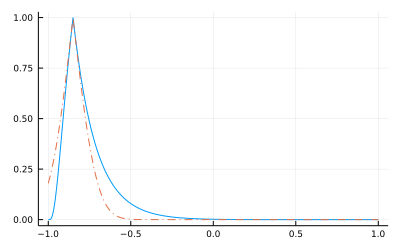

In [8]:
@show a, b, c, d = 1, 9, 19, 1
@show pvalue_rd_zou_donnerb(a, b, c, d)
@show pvalue_rd_zou_donnerb_prime(a, b, c, d)
@show pvalue_rd_wald(a, b, c, d)

plot(Δ -> pvalue_rd_zou_donnerb(a, b, c, d; Δ), -1, 1; label="")
#plot!(Δ -> pvalue_rd_zou_donnerb_prime(a, b, c, d; Δ), -1, 1; label="", ls=:dash)
plot!(Δ -> pvalue_rd_wald(a, b, c, d; Δ), -1, 1; label="", ls=:dashdot)

(a, b, c, d) = (1, 9, 19, 1) = (1, 9, 19, 1)
pvalue_rd_zou_donnerb(a, b, c, d) = 0.0018219662578444458
pvalue_rd_zou_donnerb_prime(a, b, c, d) = 2.733391312410812e-29
pvalue_rd_wald(a, b, c, d) = 2.901697212562893e-14


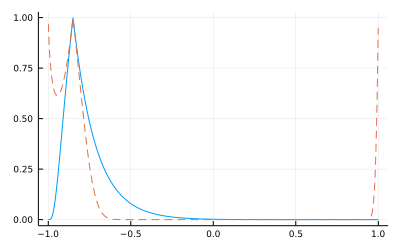

In [9]:
@show a, b, c, d = 1, 9, 19, 1
@show pvalue_rd_zou_donnerb(a, b, c, d)
@show pvalue_rd_zou_donnerb_prime(a, b, c, d)
@show pvalue_rd_wald(a, b, c, d)

plot(Δ -> pvalue_rd_zou_donnerb(a, b, c, d; Δ), -1, 1; label="")
plot!(Δ -> pvalue_rd_zou_donnerb_prime(a, b, c, d; Δ), -1, 1; label="", ls=:dash)
#plot!(Δ -> pvalue_rd_wald(a, b, c, d; Δ), -1, 1; label="", ls=:dashdot)

In [10]:
function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? typeof(ω)(-min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction)
end

function pvalue_or_pearson_chisq(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

function confint_or_pearson_chisq(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_pearson_chisq(a, b, c, d; ω=exp(logω), correction)) - logit(α)
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        ω_L, ω_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
    end
end

confint_or_pearson_chisq (generic function with 1 method)

In [11]:
oddsratiohat(a, b, c, d) = safediv(a*d, b*c)

function sim_alphaerrors(m, n, p, q=p; L=10^5)
    Δ = p - q
    ω = safediv(p*(1-q), (1-p)*q)
    bin1, bin2 = Binomial(m, p), Binomial(n, q)
    pval_wald = similar(zeros(), L)
    pval_zou_donnerb = similar(zeros(), L)
    pval_chisq = similar(zeros(), L)
    Threads.@threads for i in 1:L
        a, c = rand(bin1), rand(bin2)
        b, d = m-a, n-c
        pval_wald[i] = pvalue_rd_wald(a, b, c, d; Δ)
        pval_zou_donnerb[i] = pvalue_rd_zou_donnerb(a, b, c, d; Δ)
        pval_chisq[i] = pvalue_or_pearson_chisq(a, b, c, d; ω)
    end
    ecdf_wald = ecdf(pval_wald)
    ecdf_zou_donnerb = ecdf(pval_zou_donnerb)
    ecdf_chisq = ecdf(pval_chisq)
    F_wald(x) = ecdf_wald(x)
    F_zou_donnerb(x) = ecdf_zou_donnerb(x)
    F_chisq(x) = ecdf_chisq(x)
    (; F_wald, F_zou_donnerb, F_chisq)
end

function plot_alphaerrors(m, n, p, q=p; L=10^5, kwargs...)
    (; F_wald, F_zou_donnerb, F_chisq) = sim_alphaerrors(m, n, p, q)
    plot(legend=:topleft)
    plot!(F_zou_donnerb, 0, 0.1; label="ZD")
    plot!(F_wald, 0, 0.1; label="Wald", ls=:dash)
    plot!(F_chisq, 0, 0.1; label="chisq", ls=:dashdot)
    plot!(identity, 0, 0.1; label="", c=:red, ls=:dot, alpha=0.7)
    plot!(xtick=0:0.01:1, ytick=0:0.01:1)
    plot!(size=(400, 400))
    plot!(; kwargs...)
end

plot_alphaerrors (generic function with 2 methods)

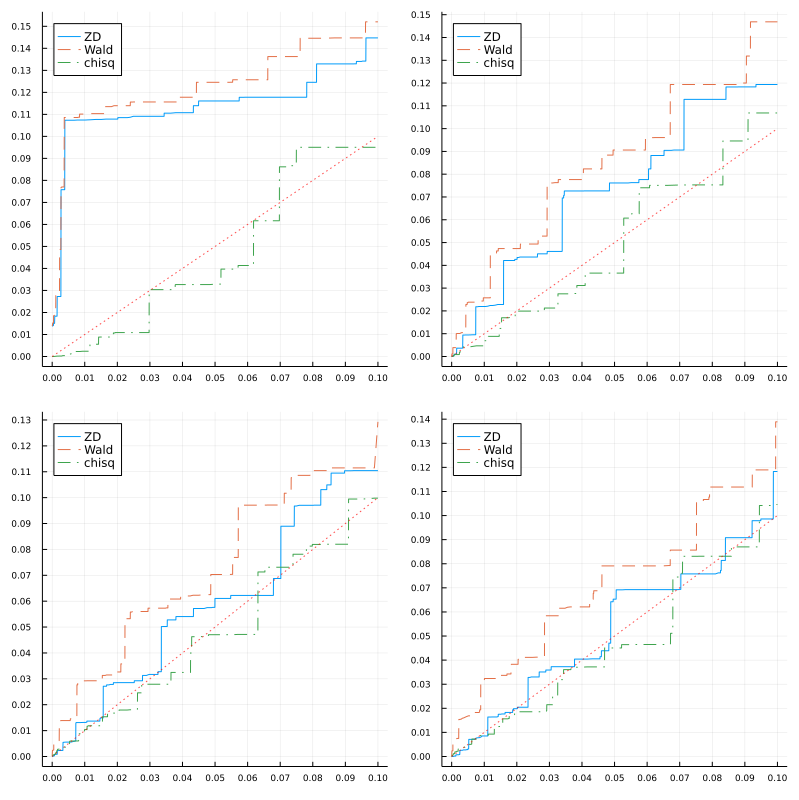

In [12]:
m, n, p = 10, 20, 0.2
PP = []
for q in (0.1, 0.2, 0.3, 0.4)
    P = plot_alphaerrors(m, n, p, q)
    push!(PP, P)
end
plot(PP...; size=(800, 800), layout=(2, 2))

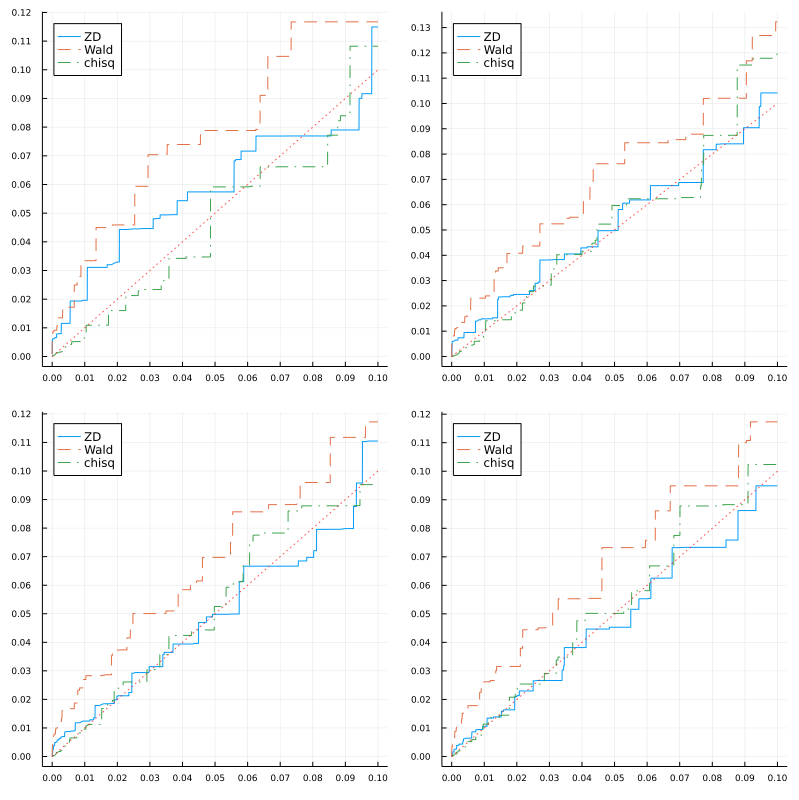

In [13]:
m, n, p = 10, 20, 0.4
PP = []
for q in (0.1, 0.2, 0.3, 0.4)
    P = plot_alphaerrors(m, n, p, q)
    push!(PP, P)
end
plot(PP...; size=(800, 800), layout=(2, 2))

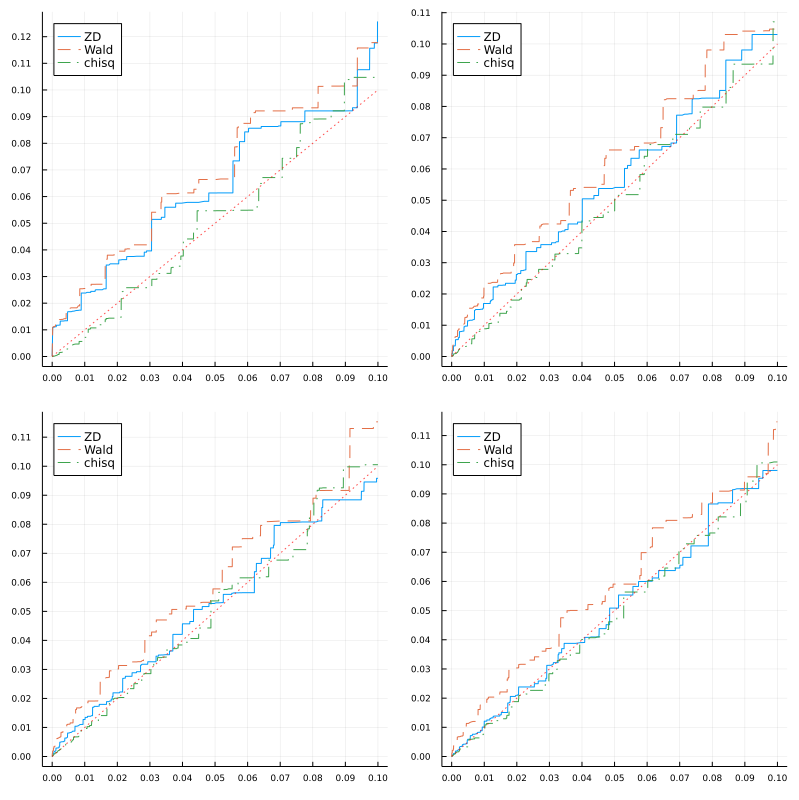

In [14]:
m, n, p = 20, 40, 0.2
PP = []
for q in (0.1, 0.2, 0.3, 0.4)
    P = plot_alphaerrors(m, n, p, q)
    push!(PP, P)
end
plot(PP...; size=(800, 800), layout=(2, 2))

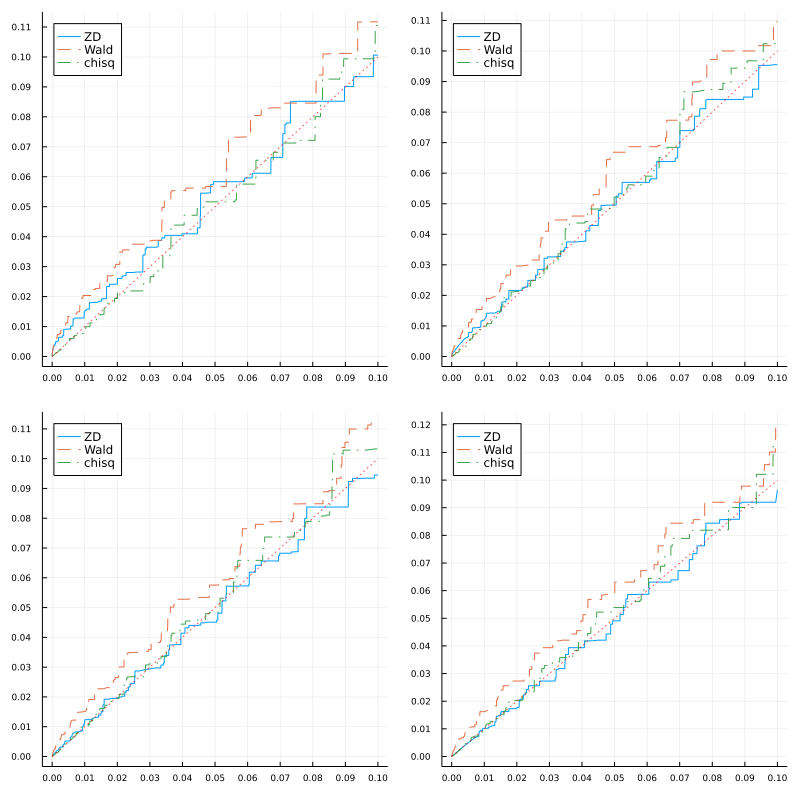

In [15]:
m, n, p = 20, 40, 0.4
PP = []
for q in (0.1, 0.2, 0.3, 0.4)
    P = plot_alphaerrors(m, n, p, q)
    push!(PP, P)
end
plot(PP...; size=(800, 800), layout=(2, 2))

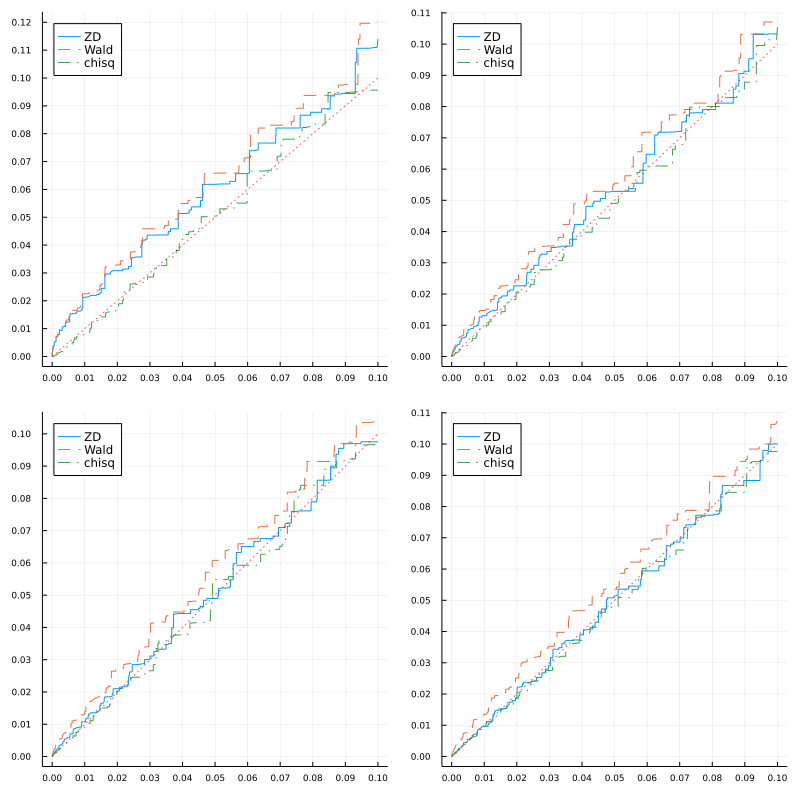

In [16]:
m, n, p = 30, 60, 0.2
PP = []
for q in (0.1, 0.2, 0.3, 0.4)
    P = plot_alphaerrors(m, n, p, q)
    push!(PP, P)
end
plot(PP...; size=(800, 800), layout=(2, 2))

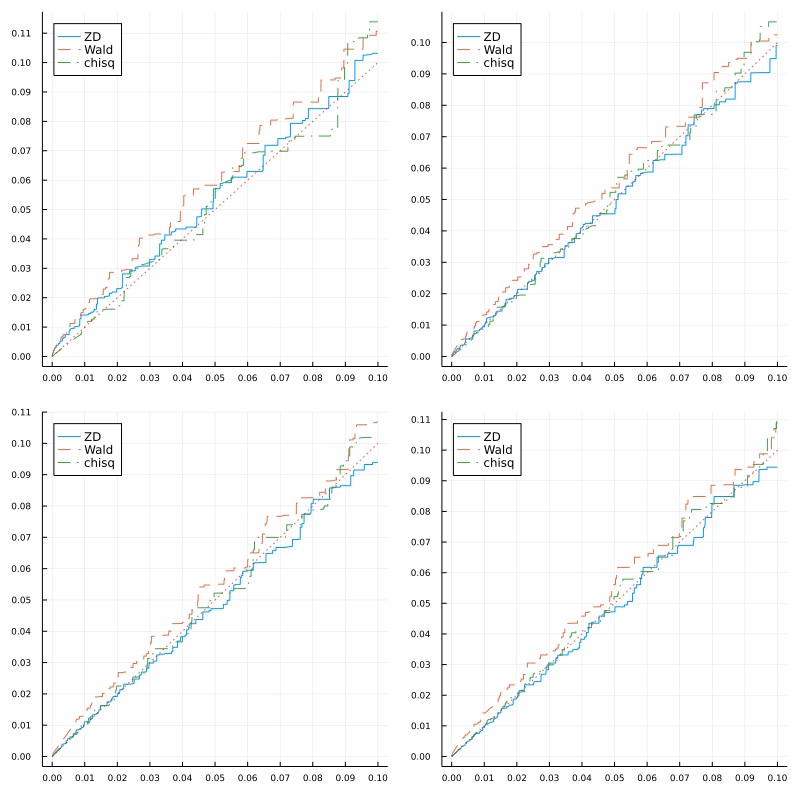

In [17]:
m, n, p = 30, 60, 0.4
PP = []
for q in (0.1, 0.2, 0.3, 0.4)
    P = plot_alphaerrors(m, n, p, q)
    push!(PP, P)
end
plot(PP...; size=(800, 800), layout=(2, 2))

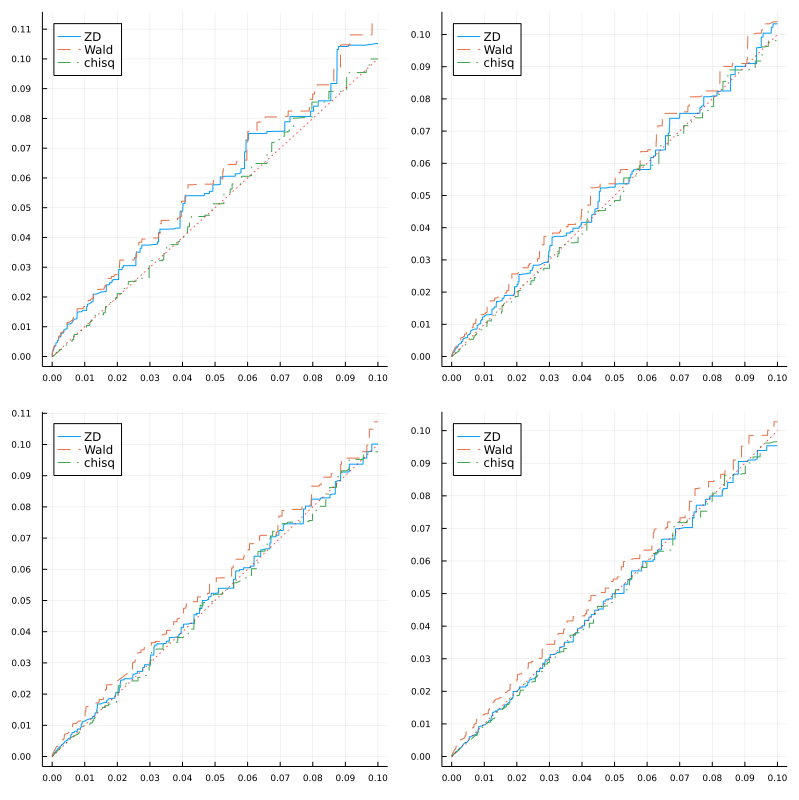

In [18]:
m, n, p = 40, 80, 0.2
PP = []
for q in (0.1, 0.2, 0.3, 0.4)
    P = plot_alphaerrors(m, n, p, q)
    push!(PP, P)
end
plot(PP...; size=(800, 800), layout=(2, 2))

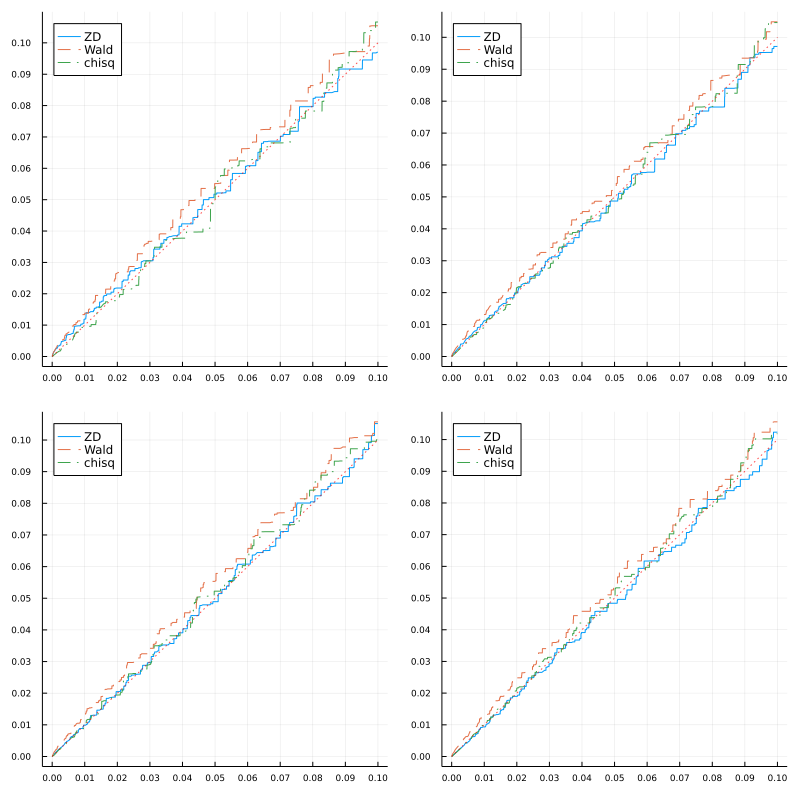

In [19]:
m, n, p = 40, 80, 0.4
PP = []
for q in (0.1, 0.2, 0.3, 0.4)
    P = plot_alphaerrors(m, n, p, q)
    push!(PP, P)
end
plot(PP...; size=(800, 800), layout=(2, 2))

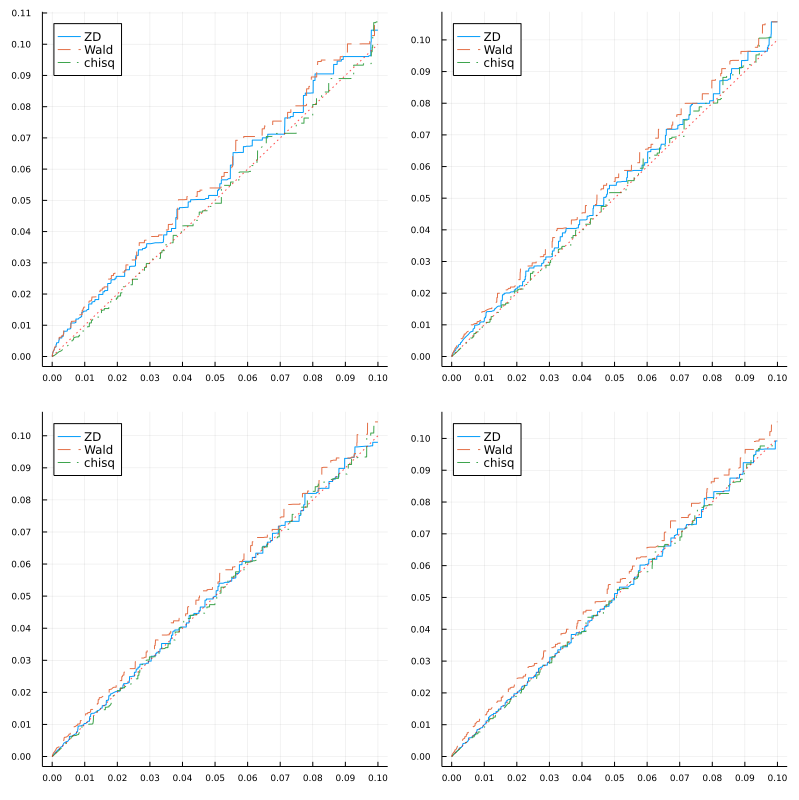

In [20]:
m, n, p = 50, 100, 0.2
PP = []
for q in (0.1, 0.2, 0.3, 0.4)
    P = plot_alphaerrors(m, n, p, q)
    push!(PP, P)
end
plot(PP...; size=(800, 800), layout=(2, 2))

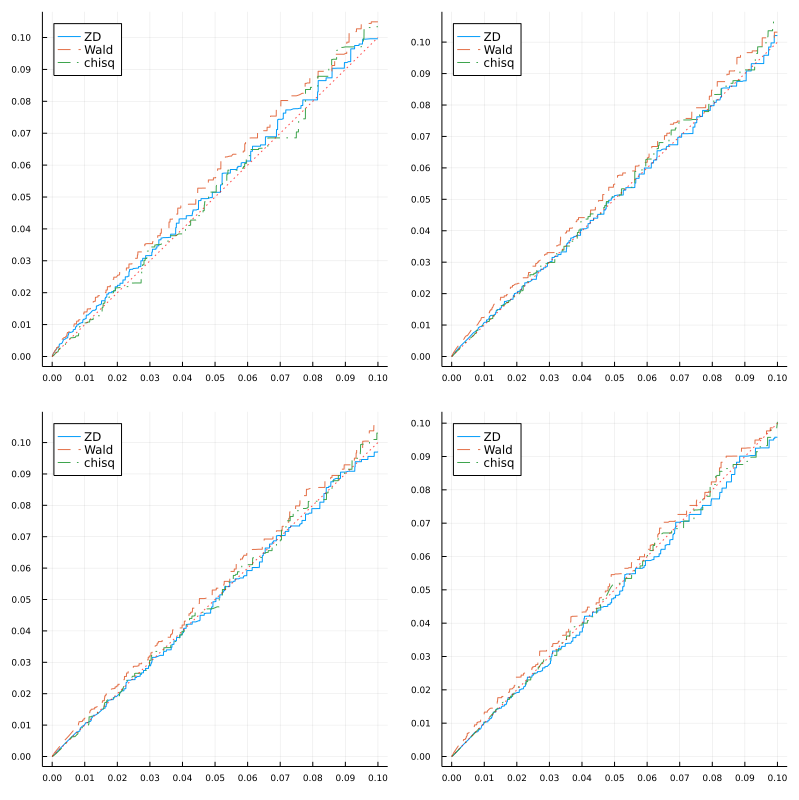

In [21]:
m, n, p = 50, 100, 0.4
PP = []
for q in (0.1, 0.2, 0.3, 0.4)
    P = plot_alphaerrors(m, n, p, q)
    push!(PP, P)
end
plot(PP...; size=(800, 800), layout=(2, 2))

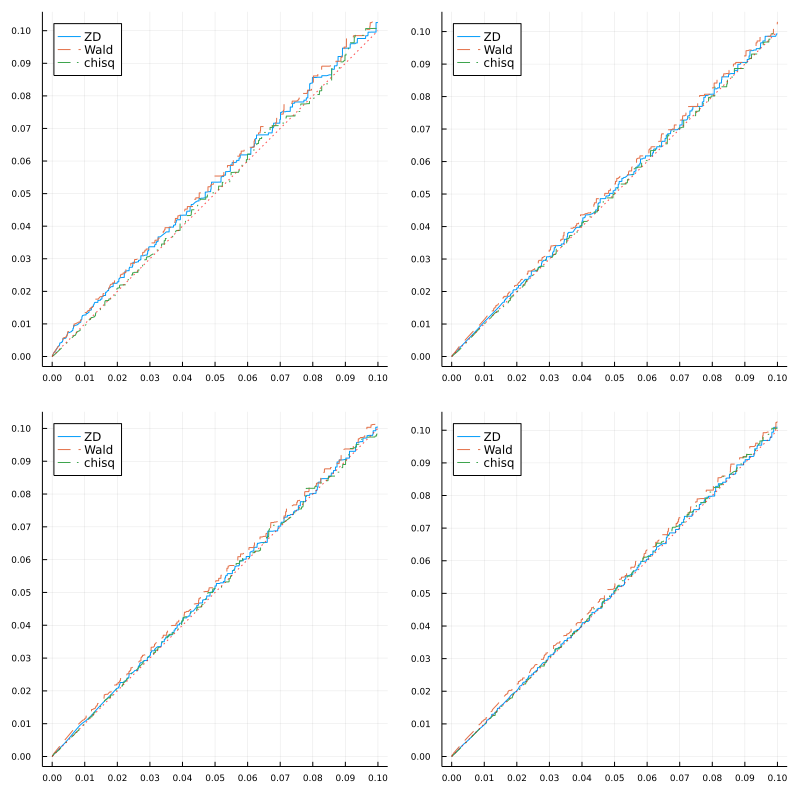

In [22]:
m, n, p = 100, 200, 0.2
PP = []
for q in (0.1, 0.2, 0.3, 0.4)
    P = plot_alphaerrors(m, n, p, q)
    push!(PP, P)
end
plot(PP...; size=(800, 800), layout=(2, 2))

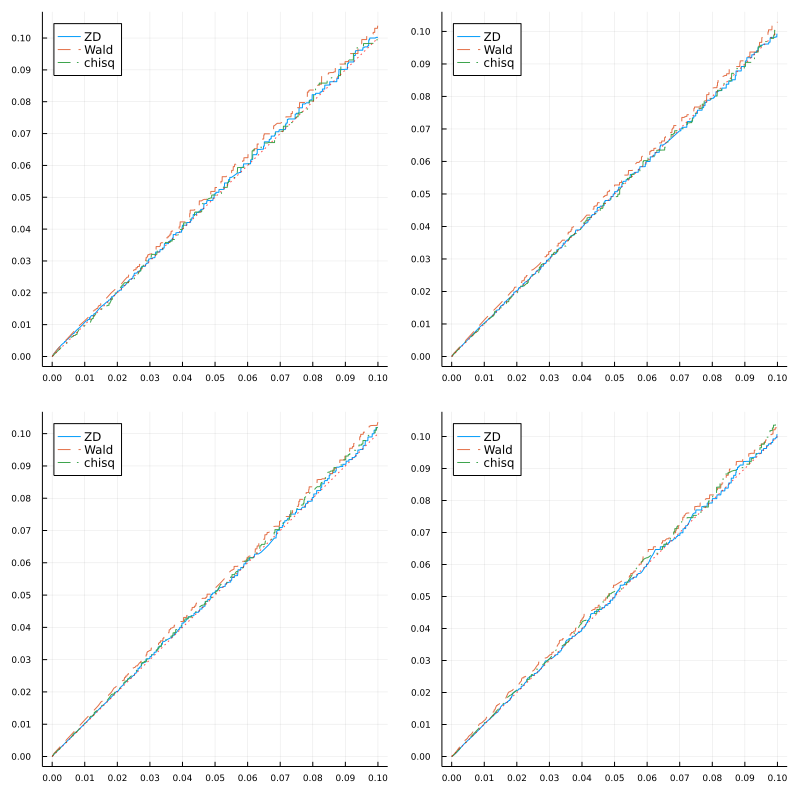

In [23]:
m, n, p = 100, 200, 0.4
PP = []
for q in (0.1, 0.2, 0.3, 0.4)
    P = plot_alphaerrors(m, n, p, q)
    push!(PP, P)
end
plot(PP...; size=(800, 800), layout=(2, 2))